In [4]:
# load the change in the files
%load_ext autoreload
%autoreload 2

In [5]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import numpy as np

## Defining the forward diffusion process


In [6]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

To start with, let's use the linear schedule for \\(T=200\\) time steps and define the various variables from the \\(\beta_t\\) which we will need, such as the cumulative product of the variances \\(\bar{\alpha}_t\\). Each of the variables below are just 1-dimensional tensors, storing values from \\(t\\) to \\(T\\). Importantly, we also define an `extract` function, which will allow us to extract the appropriate \\(t\\) index for a batch of indices.


In [7]:
timesteps = 500

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [8]:
import os
import sys
# append the parent directory to path
# sys.path.append('/home/miyen/diffusion-features/diffusion-features')
sys.path.append('/Users/sagarpatil/sagar/projects/diffusion-features/diffusion-features/')
from utils.get_trajectories import get_trajectories
trajectories = get_trajectories()
trajectories = torch.tensor(trajectories, dtype=torch.float32)
print(trajectories.shape)
x_start = trajectories[30].unsqueeze(0)
x_start = x_start.float()
print(x_start)

/Users/sagarpatil/sagar/projects/diffusion-features/environment/data/lavaenv
torch.Size([1033, 64, 2])
torch.Size([1033, 64, 2])
tensor([[[1.0000, 4.0000],
         [1.0000, 3.7500],
         [1.0000, 3.5000],
         [1.0000, 3.2500],
         [1.0000, 3.0000],
         [1.0000, 2.7500],
         [1.0000, 2.5000],
         [1.0000, 2.2500],
         [1.0000, 2.0000],
         [1.2500, 2.0000],
         [1.5000, 2.0000],
         [1.7500, 2.0000],
         [2.0000, 2.0000],
         [2.2500, 2.0000],
         [2.5000, 2.0000],
         [2.7500, 2.0000],
         [3.0000, 2.0000],
         [3.2500, 2.0000],
         [3.5000, 2.0000],
         [3.7500, 2.0000],
         [4.0000, 2.0000],
         [4.2500, 2.0000],
         [4.5000, 2.0000],
         [4.7500, 2.0000],
         [5.0000, 2.0000],
         [5.2500, 2.0000],
         [5.5000, 2.0000],
         [5.7500, 2.0000],
         [6.0000, 2.0000],
         [6.2500, 2.0000],
         [6.5000, 2.0000],
         [6.7500, 2.0000],
       

/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_81725/1557794813.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trajectories = torch.tensor(trajectories, dtype=torch.float32)


In [9]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

Let's test it on a particular time step:

In [10]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  # noisy_image = reverse_transform(x_noisy.squeeze())

  return x_noisy

In [11]:
# take time step
t = torch.tensor([40])

x_noisy = get_noisy_image(x_start, t)


<img src="https://drive.google.com/uc?id=1Ra33wxuw3QxPlUG0iqZGtxgKBNdjNsqz" width="100" />

Let's visualize this for various time steps:

tensor([[[1.0000, 4.0000],
         [1.0000, 3.7500],
         [1.0000, 3.5000],
         [1.0000, 3.2500],
         [1.0000, 3.0000],
         [1.0000, 2.7500],
         [1.0000, 2.5000],
         [1.0000, 2.2500],
         [1.0000, 2.0000],
         [1.2500, 2.0000],
         [1.5000, 2.0000],
         [1.7500, 2.0000],
         [2.0000, 2.0000],
         [2.2500, 2.0000],
         [2.5000, 2.0000],
         [2.7500, 2.0000],
         [3.0000, 2.0000],
         [3.2500, 2.0000],
         [3.5000, 2.0000],
         [3.7500, 2.0000],
         [4.0000, 2.0000],
         [4.2500, 2.0000],
         [4.5000, 2.0000],
         [4.7500, 2.0000],
         [5.0000, 2.0000],
         [5.2500, 2.0000],
         [5.5000, 2.0000],
         [5.7500, 2.0000],
         [6.0000, 2.0000],
         [6.2500, 2.0000],
         [6.5000, 2.0000],
         [6.7500, 2.0000],
         [7.0000, 2.0000],
         [7.2500, 2.0000],
         [7.5000, 2.0000],
         [7.7500, 2.0000],
         [8.0000, 2.0000],
 

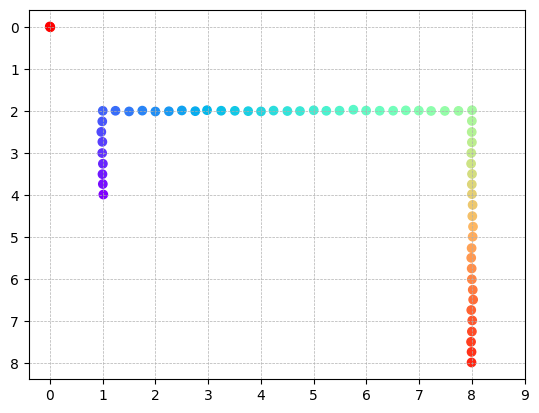

tensor([[[ 0.7267,  4.1100],
         [ 0.6534,  3.5437],
         [ 1.5527,  3.2358],
         [ 1.0226,  2.7432],
         [ 0.8504,  3.3598],
         [ 0.7753,  2.3509],
         [ 1.0071,  2.3307],
         [ 0.7682,  2.1262],
         [ 0.9354,  2.0578],
         [ 0.9639,  2.2895],
         [ 0.8315,  2.2062],
         [ 1.6952,  1.7756],
         [ 2.3896,  2.3027],
         [ 2.2467,  2.0425],
         [ 2.8462,  1.8446],
         [ 2.9662,  2.1199],
         [ 3.1077,  1.7987],
         [ 3.1686,  1.9293],
         [ 3.5147,  2.1258],
         [ 3.4164,  2.0784],
         [ 3.8623,  2.1366],
         [ 4.3100,  1.8850],
         [ 4.0368,  1.7732],
         [ 4.9944,  1.8121],
         [ 4.9311,  2.0130],
         [ 5.7940,  2.0653],
         [ 5.0082,  2.3917],
         [ 5.5010,  1.8387],
         [ 5.9468,  1.7996],
         [ 5.9881,  1.9224],
         [ 6.5067,  2.2670],
         [ 6.5833,  2.0604],
         [ 6.6358,  1.5697],
         [ 6.9915,  2.0869],
         [ 7.1

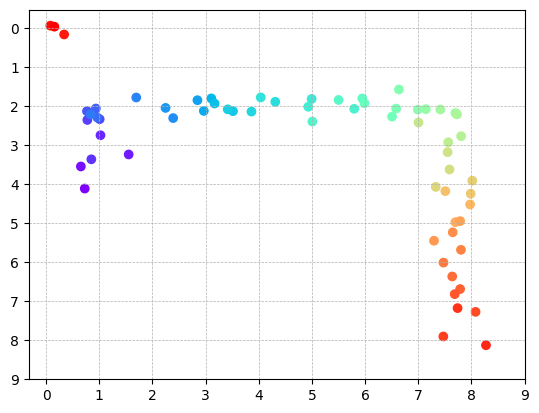

tensor([[[ 1.0421,  4.3087],
         [ 0.8605,  3.4424],
         [ 1.2208,  3.2797],
         [ 1.0696,  2.1729],
         [ 1.4524,  1.9711],
         [ 0.5496,  2.3271],
         [ 0.8259,  1.2674],
         [ 1.0876,  1.3791],
         [ 0.9389,  1.9584],
         [ 1.3090,  2.0283],
         [ 0.8953,  2.0339],
         [ 1.2438,  1.5597],
         [ 1.3642,  1.6483],
         [ 1.5018,  2.5274],
         [ 1.7165,  1.6385],
         [ 2.5921,  1.5900],
         [ 2.1976,  1.3937],
         [ 3.1839,  2.0920],
         [ 3.5520,  2.0705],
         [ 3.6692,  1.3773],
         [ 2.8051,  0.9303],
         [ 3.6265,  1.6745],
         [ 4.4346,  2.1841],
         [ 3.0412,  2.3332],
         [ 4.3877,  2.1974],
         [ 5.6132,  1.2102],
         [ 5.2346,  1.2419],
         [ 5.0595,  2.1242],
         [ 5.4728,  2.1877],
         [ 4.9683,  1.3605],
         [ 6.8128,  1.4912],
         [ 6.4207,  1.1874],
         [ 6.6912,  1.2462],
         [ 6.3513,  1.6400],
         [ 6.9

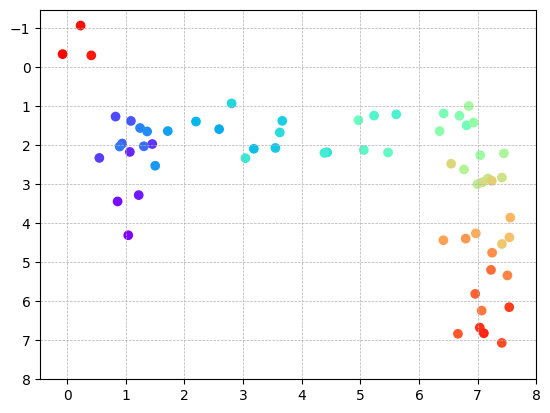

tensor([[[ 0.9667,  3.3088],
         [-0.1595,  1.7655],
         [ 0.0274,  2.8745],
         [ 0.9741,  2.4584],
         [ 0.1140,  2.2642],
         [ 1.0524,  1.1477],
         [ 0.8400,  3.0012],
         [ 0.7317,  2.1881],
         [ 0.7109,  1.9545],
         [ 1.0562,  1.8053],
         [ 0.3187,  2.3791],
         [ 2.0257,  0.9273],
         [ 1.0428,  0.9248],
         [ 2.7194,  0.7427],
         [ 1.6876,  1.7438],
         [ 2.3790,  1.8423],
         [ 2.5635,  0.6885],
         [ 2.4826,  1.1461],
         [ 2.5990,  0.1207],
         [ 3.2048,  2.0338],
         [ 3.9379,  2.1339],
         [ 2.1879,  1.7505],
         [ 3.1098,  2.0336],
         [ 4.1113,  2.1543],
         [ 3.5730,  2.5234],
         [ 5.7145,  1.7214],
         [ 4.6866,  2.2759],
         [ 3.3435,  2.0977],
         [ 4.7221,  1.5136],
         [ 3.7005,  0.6056],
         [ 5.8390,  1.3845],
         [ 4.6597,  1.3833],
         [ 4.8176,  2.2586],
         [ 5.9334,  0.7290],
         [ 6.4

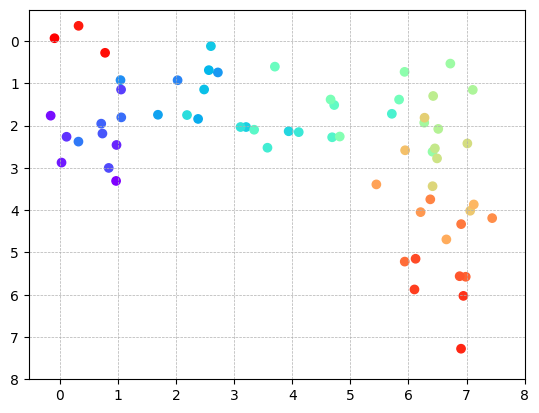

tensor([[[-0.2765,  2.8289],
         [ 0.7686,  0.7551],
         [ 0.5569,  1.2501],
         [ 1.2651,  0.4885],
         [-0.8314, -0.0939],
         [-0.4225,  0.8350],
         [ 0.7525, -0.3676],
         [-0.3418, -0.5436],
         [-0.5900,  1.3327],
         [-0.0919, -0.3513],
         [ 2.0019, -2.0476],
         [ 0.8928, -0.5428],
         [-1.6521, -0.4105],
         [-0.4358, -0.3599],
         [-0.5234,  1.3051],
         [-0.9237,  1.0674],
         [ 1.1267, -0.7994],
         [ 1.8437, -0.9575],
         [ 1.8320, -0.0738],
         [ 0.4747,  0.0872],
         [ 0.6941,  0.0304],
         [ 0.7261, -1.9310],
         [ 2.6951,  0.1928],
         [ 1.7341, -1.1686],
         [ 0.4614,  0.7625],
         [-1.5112, -1.2656],
         [ 2.5410,  1.9775],
         [ 0.4014,  1.6495],
         [ 0.8785, -0.2056],
         [ 1.5792, -0.3995],
         [ 0.8025,  1.7734],
         [ 1.6545,  0.8622],
         [ 0.4890,  0.2503],
         [ 0.0301,  1.3684],
         [ 1.3

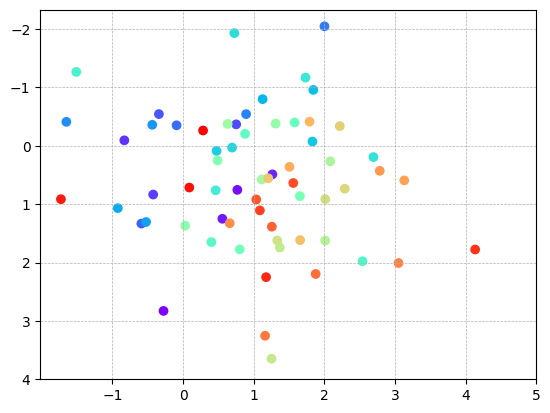

tensor([[[ 0.5607, -0.9323],
         [ 0.1542, -0.4277],
         [ 0.6688, -0.1349],
         [ 0.5034,  0.3706],
         [-0.4343,  1.4648],
         [-0.8035,  0.1547],
         [-0.4299,  0.5483],
         [ 1.3371, -0.1538],
         [ 0.1282, -0.7900],
         [-0.0736, -0.7223],
         [-1.5155,  0.1469],
         [ 0.0273,  1.4103],
         [ 0.7680, -0.5900],
         [ 0.0130, -0.9116],
         [ 0.5492, -1.4836],
         [ 0.5539,  0.2030],
         [-1.2458, -0.1329],
         [ 0.1650, -0.5374],
         [ 0.8978,  0.1081],
         [-0.2589, -0.9794],
         [ 1.8874, -2.1693],
         [-0.2808,  0.0951],
         [ 0.6484, -0.0482],
         [ 0.5069,  1.6067],
         [-1.1148, -0.1892],
         [-1.0356,  1.5072],
         [ 1.3556,  0.7631],
         [ 0.0173, -0.4528],
         [ 0.4963, -0.4046],
         [-0.8974, -0.8755],
         [ 1.0725,  0.2297],
         [-0.3488,  0.6170],
         [-0.1411,  0.4358],
         [ 0.0798,  0.8504],
         [ 0.2

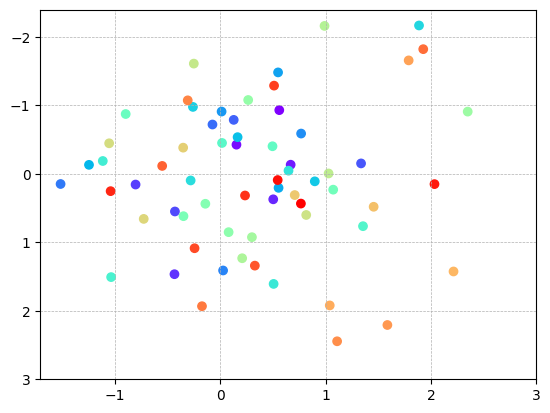

In [12]:
# plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])
from utils.get_trajectories import visualize_trajectory
# normalize the x_start by the size of the maze which is 8
print(x_start)
# x_start_normalized = x_start / 8
# print(torch.mean(x_start_normalized))
# print(torch.std(x_start_normalized))
# # make them in range [-1, 1]
# x_start_normalized = (x_start_normalized * 2) - 1
# print(x_start_normalized)

for t in [0, 50, 100, 150, 400, 499]:
  x_noisy = get_noisy_image(x_start, torch.tensor([t]))
  print(x_noisy)
    # print the mean and std of the noisy image
    # print(torch.mean(x_noisy))
    # print(torch.std(x_noisy))
  visualize_trajectory(x_noisy)

In [13]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1", condition=None):
    if noise is None:
        noise = torch.randn_like(x_start)
        
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    print("x_noisy", x_noisy.shape)
    predicted_noise = denoise_model(x_noisy, t, global_cond=condition)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [14]:
@torch.no_grad()
def p_sample(model, x, t, t_index, global_cond=None):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, global_cond) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape, global_cond=None):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, global_cond=global_cond)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

@torch.no_grad()
def sample_trajectories(model, traj_size, batch_size=16, output_dim = 2, global_cond=None):
    return p_sample_loop(model, shape=(batch_size, traj_size, output_dim), global_cond=global_cond)


Note that the code above is a simplified version of the original implementation. We found our simplification (which is in line with Algorithm 2 in the paper) to work just as well as the [original, more complex implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/diffusion_utils.py).


## Train the model

Next, we train the model in regular PyTorch fashion. We also define some logic to peridiocally save generated images, using the `sample` method defined above.


In [15]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

Below, we define the model, and move it to the GPU. We also define a standard optimizer (Adam).

In [16]:
# Taken from https://diffusion-policy.cs.columbia.edu/
import logging
import math
from typing import List, Optional, Tuple, Union
import typing

import torch
from torch import nn

# @markdown ### **Network**
# @markdown
# @markdown Defines a 1D UNet architecture `ConditionalUnet1D`
# @markdown as the noies prediction network
# @markdown
# @markdown Components
# @markdown - `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
# @markdown - `Downsample1d` Strided convolution to reduce temporal resolution
# @markdown - `Upsample1d` Transposed convolution to increase temporal resolution
# @markdown - `Conv1dBlock` Conv1d --> GroupNorm --> Mish
# @markdown - `ConditionalResidualBlock1D` Takes two inputs `x` and `cond`. \
# @markdown `x` is passed through 2 `Conv1dBlock` stacked together with residual connection.
# @markdown `cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        print('emb shape:', emb.shape)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    """
    Conv1d --> GroupNorm --> Mish
    """

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, kernel_size=3, n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList(
            [
                Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups,),
                Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups,),
            ]
        )

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(), nn.Linear(cond_dim, cond_channels,), nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = (
            nn.Conv1d(in_channels, out_channels, 1,)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, cond):
        """
        x : [ batch_size x in_channels x horizon ]
        cond : [ batch_size x cond_dim]

        returns:
        out : [ batch_size x out_channels x horizon ]
        """
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:, 0, ...]
        bias = embed[:, 1, ...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(
        self,
        input_dim: int,
        global_cond_dim: int,
        down_dims: List[int],
        diffusion_step_embed_dim: int,
        kernel_size: int = 5,
        n_groups: int = 8,
    ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines number of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList(
            [
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
            ]
        )

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_out,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Downsample1d(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_out * 2,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Upsample1d(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size, n_groups=n_groups),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

    def forward(
        self,
        sample: torch.Tensor,
        timestep: torch.Tensor,
        global_cond: Optional[torch.Tensor] = None,
    ):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B, global_cond_dim)
        output: (B,T,input_dim)
        """
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

        # (B,T,C)
        sample = sample.moveaxis(-1, -2)
        print('sample shape:', sample.shape)

        # 1. time
        timesteps = timestep
        if timesteps.shape == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])
        timesteps = timesteps.to(sample.device)

        global_feature = self.diffusion_step_encoder(timesteps)
        global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)

        if global_cond is not None:
            global_feature = torch.cat([global_feature, global_cond], axis=-1)

        x = sample
        h = []
        # print('downsampling')
        for resnet, resnet2, downsample in self.down_modules:
            # print('x shape:', x.shape)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            # print('h shape:', h[-1].shape)
            x = downsample(x)


        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)
        # print('upsampling')
        for resnet, resnet2, upsample in self.up_modules:
            print('x shape:', x.shape)
            print('h shape:', h[-1].shape)
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)
        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1, -2)
        # (B,T,C)
        return x

In [17]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
# trajectories = trajectories[0:32]
trajectories_size = trajectories.shape
print(trajectories_size)
# model = Unet(
#     dim=trajectories_size[1],
#     channels=channels,
#     dim_mults=(1, 2, 4,)
# )
# TODO: double check down_dims
model = ConditionalUnet1D(
    input_dim=2,
    global_cond_dim=0,
    # global_cond_dim=4,
    down_dims=[16, 32, 64],
    diffusion_step_embed_dim=trajectories_size[1],
    kernel_size=3,
    n_groups=1,
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

torch.Size([1033, 64, 2])


Let's start training!

In [18]:
# print the total number of trajectories
print(trajectories.shape)


torch.Size([1033, 64, 2])


In [19]:
from torchvision.utils import save_image
from torch.utils.data import DataLoader

epochs = 300
batch_size = 32
# channels = 1
dataloader = DataLoader(trajectories, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()
      
      
      b = batch.shape[0]
      batch = batch.to(device)
      # batch shape: (B, T, C)
      print('input shape pre reshape', batch.shape)

      # batch = batch.reshape(b, channels, batch.shape[1], batch.shape[2])
      
      # normalize the batch to [-1, 1]
      batch = (batch / 8) * 2 - 1
      
      # generate conditioning based on start and end states
      start_states = batch[:, 0, :]
      end_states = batch[:, -1, :]
      condition = torch.cat((start_states, end_states), axis=1)
      # print(condition)
      condition = None
      # print('condition shape', condition.shape)
      
      # print("batch: ", torch.mean(batch[4]), torch.std(batch[4]))
      # print("Max and min", torch.max(batch[4]), torch.min(batch[4]))

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()
      if b != batch_size:
         continue
      loss = p_losses(model, batch, t, loss_type="huber", condition=condition)

      # if step % 100 == 0:
      print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      # if step != 0 and step % save_and_sample_every == 0:
      #   milestone = step // save_and_sample_every
      #   batches = num_to_groups(4, batch_size)
      #   all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
      #   all_images = torch.cat(all_images_list, dim=0)
      #   all_images = (all_images + 1) * 0.5
      #   save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

input shape pre reshape torch.Size([32, 64, 2])
x_noisy torch.Size([32, 64, 2])
sample shape: torch.Size([32, 2, 64])
emb shape: torch.Size([32, 64])
x shape: torch.Size([32, 64, 16])
h shape: torch.Size([32, 64, 16])
x shape: torch.Size([32, 32, 32])
h shape: torch.Size([32, 32, 32])
Loss: 0.5399265885353088


/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_81725/1160084620.py:266: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)


input shape pre reshape torch.Size([32, 64, 2])
x_noisy torch.Size([32, 64, 2])
sample shape: torch.Size([32, 2, 64])
emb shape: torch.Size([32, 64])
x shape: torch.Size([32, 64, 16])
h shape: torch.Size([32, 64, 16])
x shape: torch.Size([32, 32, 32])
h shape: torch.Size([32, 32, 32])
Loss: 0.47517913579940796
input shape pre reshape torch.Size([32, 64, 2])
x_noisy torch.Size([32, 64, 2])
sample shape: torch.Size([32, 2, 64])
emb shape: torch.Size([32, 64])
x shape: torch.Size([32, 64, 16])
h shape: torch.Size([32, 64, 16])
x shape: torch.Size([32, 32, 32])
h shape: torch.Size([32, 32, 32])
Loss: 0.4240419864654541
input shape pre reshape torch.Size([32, 64, 2])
x_noisy torch.Size([32, 64, 2])
sample shape: torch.Size([32, 2, 64])
emb shape: torch.Size([32, 64])
x shape: torch.Size([32, 64, 16])
h shape: torch.Size([32, 64, 16])
x shape: torch.Size([32, 32, 32])
h shape: torch.Size([32, 32, 32])
Loss: 0.4381699562072754
input shape pre reshape torch.Size([32, 64, 2])
x_noisy torch.Size

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [134]:
global_cond = torch.tensor([2, 2, 7, 4]).unsqueeze(0).to(device)
# convert condition to [-1, 1]
global_cond = (global_cond / 8) * 2 - 1
# print(global_cond)
global_cond = None
samples = sample_trajectories(model=model, traj_size=16, batch_size=1, output_dim=2, global_cond=global_cond)
print(len(samples))

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_51800/566316448.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)
sampling loop time step: 100%|██████████| 500/500 [00:01<00:00, 498.12it/s]

500


(1, 16, 2)
[[[-0.6669221   4.1510024 ]
  [ 7.3694215   7.2047186 ]
  [ 0.68968487  3.521986  ]
  [ 4.9884377   1.2692726 ]
  [12.98297     2.805747  ]
  [ 5.5078106  -2.4587111 ]
  [ 5.883621    6.713678  ]
  [-0.5198765   7.4989905 ]
  [ 4.5584946   4.77086   ]
  [-0.9716158   4.7705345 ]
  [ 3.9120753  -1.3135657 ]
  [ 8.844958    6.5085726 ]
  [-2.496851    3.139196  ]
  [ 3.677752    0.7836528 ]
  [ 3.026744    1.6479924 ]
  [ 9.473103    4.132858  ]]]


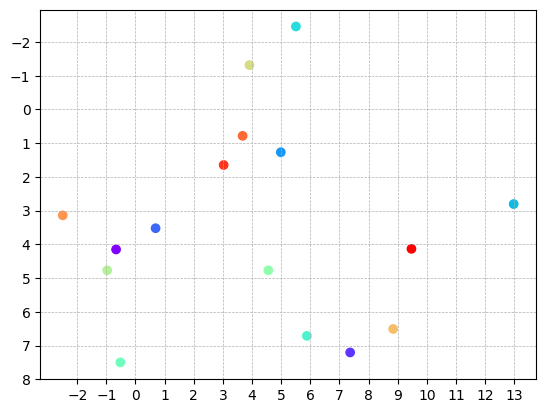

(1, 16, 2)
[[[ 5.9705544   8.057604  ]
  [ 7.4110856   9.312624  ]
  [-0.06755733  5.6914473 ]
  [ 6.9795957   3.8825462 ]
  [ 4.654438    5.0745554 ]
  [ 6.079726    1.8833106 ]
  [ 6.2156262   1.5123    ]
  [ 0.5933752   3.1342402 ]
  [ 7.811598    3.5197911 ]
  [ 0.07504964  2.8294072 ]
  [ 1.1484163   2.1317582 ]
  [ 8.65299     1.6498661 ]
  [ 2.0584004   9.185118  ]
  [ 5.350906    5.1971135 ]
  [ 2.7268314  -1.5846119 ]
  [ 4.284013    2.07917   ]]]


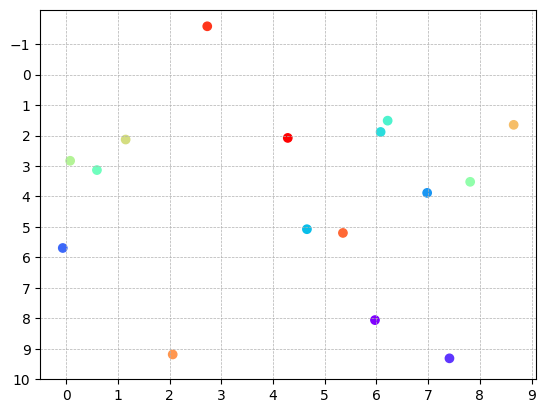

(1, 16, 2)
[[[ 7.2177005   8.079389  ]
  [ 5.954874    5.243887  ]
  [ 5.8344507   5.647771  ]
  [ 2.6712897   3.568378  ]
  [ 4.18281     5.1093626 ]
  [ 6.49615    -0.56967497]
  [-0.8772712   4.8003426 ]
  [ 4.097233   -3.7794404 ]
  [ 9.030355    4.226968  ]
  [ 1.2571621   4.515045  ]
  [ 6.021026    2.8599746 ]
  [ 5.094581   -3.488296  ]
  [ 8.435263    7.472182  ]
  [ 3.932701    0.3470683 ]
  [ 6.122687   -0.9763365 ]
  [ 9.006842    3.147798  ]]]


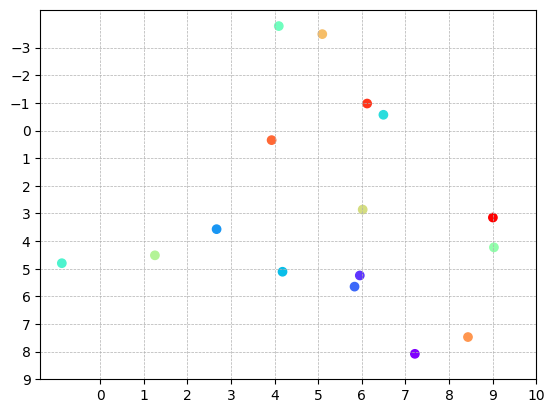

(1, 16, 2)
[[[ 8.152194    4.372538  ]
  [ 1.0159752  -0.8222122 ]
  [ 1.851769    7.9016366 ]
  [ 2.9275599  -4.2457476 ]
  [ 5.605409    3.9196115 ]
  [ 4.733534    3.7782953 ]
  [-2.4749837   1.9433334 ]
  [ 6.7473536   3.2837577 ]
  [ 8.377369   11.094244  ]
  [ 5.6469235   5.1521177 ]
  [ 5.58877     7.7038736 ]
  [ 1.2594781  -0.09961176]
  [10.778213    1.3713562 ]
  [ 3.4264781   2.1706004 ]
  [ 0.27178383 -2.4842987 ]
  [ 6.37685     7.1143064 ]]]


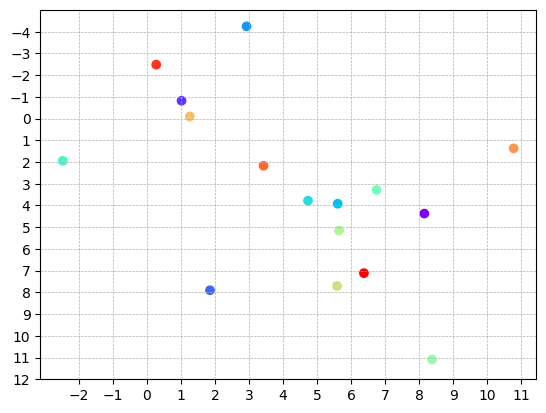

(1, 16, 2)
[[[-0.02436161  4.8962927 ]
  [ 6.509177    3.0493417 ]
  [ 3.9940724   4.660527  ]
  [ 5.728189    1.4335778 ]
  [ 5.433491    3.298255  ]
  [ 4.5872145   4.5551496 ]
  [ 7.7289233   5.6085863 ]
  [ 6.0881076   2.8887446 ]
  [ 7.335008    6.911565  ]
  [ 5.722125    4.1211    ]
  [ 6.7694616   4.1105905 ]
  [ 5.1835833   6.58709   ]
  [ 3.3635824   2.6691976 ]
  [ 0.23558426  0.5457065 ]
  [ 1.4672756   3.8267462 ]
  [ 4.676652    6.873612  ]]]


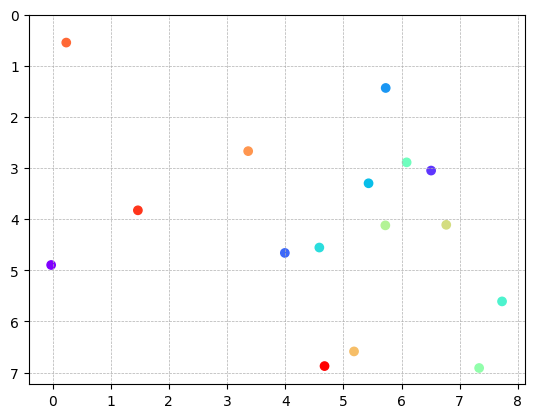

(1, 16, 2)
[[[1.9276066 2.5519905]
  [2.835239  2.1029887]
  [3.554356  2.1868544]
  [4.7955523 1.6560209]
  [6.051275  1.7263734]
  [6.5691915 1.618782 ]
  [7.038306  1.658416 ]
  [7.2196074 2.1252549]
  [7.348646  2.4274015]
  [6.5284767 2.980283 ]
  [6.5219426 3.7739563]
  [5.2522273 4.1243258]
  [4.477514  3.811285 ]
  [4.4982157 3.2059848]
  [4.5406446 2.9503999]
  [4.1599545 3.179059 ]]]


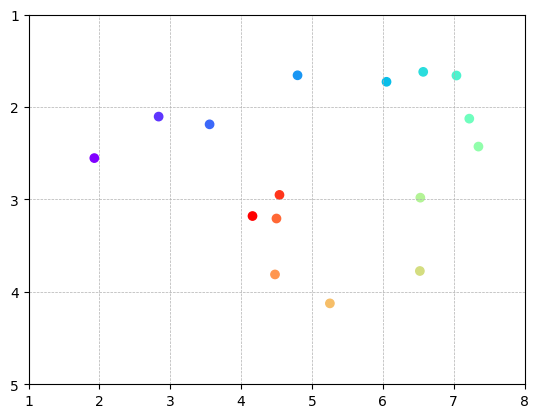

In [135]:
# show a random one
from utils.get_trajectories import visualize_trajectory
import numpy as np

# random_index = 180
# print(samples[random_index].shape)
# print(samples[random_index])
# random_sample = samples[random_index][0]
# print(np.mean(random_sample))
# print(np.std(random_sample))
# # plot the trajectory
# visualize_trajectory(random_sample)

# print the final trajectory
# samples[-1] = ((samples[-1]+1)/2) * 8 # denormalize
# print(samples[-1].shape)
# print(samples[-1])
# visualize_trajectory(samples[-1])


for i in [0, 50, 100, 200, 400, 499]:
  samples[i] = ((samples[i]+1)/2) * 8 # denormalize
  print(samples[i].shape)
  print(samples[i])
  visualize_trajectory(samples[i][:10])

<img src="https://drive.google.com/uc?id=1ytnzS7IW7ortC6ub85q7nud1IvXe2QTE" width="300" />